# __Job Satisfaction__

Job satisfaction is a significant topic for the well-being of individuals due to its multiple dimensions. The ability to choose a career, projects, and organizations that align with personal interests has a direct impact on an individual's health and happiness. Organizations that prioritize their employees in their processes and business objectives not only generate greater social well-being, but also increase their business performance. Therefore, companies like Coink should have models for predicting job satisfaction to anticipate whether a new employee will have high or low job satisfaction. Such a forecast could allow organizations to make early decisions regarding employees with a high probability of low satisfaction and promote benefits or campaigns designed to increase their satisfaction.

# __Exploratory Data Analysis__

### Importing Libraries and Loading the Job Satisfaction Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import warnings
from IPython.display import IFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier
from tensorflow import keras
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_excel("../data/info_satisfaccion_trabajo.xlsx")
df.head(3)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0


### As the purpose of this exercise is Machine Learning, I have decided to use pandas_profiling to generate a quick and comprehensive analysis of the dataset, go here __([EDA with pandas_profiling](https://davidcamilo0710.github.io/Coink))__.


In [2]:
# Generate report using pandas-profiling
# report = df.profile_report()

# Save the report to an HTML file
# report.to_file("report.html")

# View the report in the notebook
# IFrame(src='report.html', width=1000, height=600)

+ The report shows that the dataset contains 1470 observations and 35 variables, with 15 being numeric, 3 boolean, and 17 
categorical. No missing cells or duplicate rows were found in the dataset.

+ The target column (JobSatisfaction) does not have strong correlations with any variable, indicating that the performance of the models may not be good.

+ The alerts highlight some important characteristics of the dataset, including the presence of constant variables (EmployeeCount, Over18, StandardHours), and high correlations between several numeric variables, such as Age with TotalWorkingYears, MonthlyIncome with TotalWorkingYears, and PercentSalaryHike with PerformanceRating, among others. There is also high correlation between categorical variables like Department and EducationField, and JobRole and Department.

+ Overall, the pandas_profiling report provides valuable information about the dataset characteristics, including the distribution and type of variables, as well as relationships and correlations between them. It also detects constant variables and missing or zero values. This information will be useful for developing the requested supervised learning models and save some time.

# __Data Preparation__

### Summarizing the Dataset

In [3]:
def dataframe_summary(df):
    # Number of rows and columns
    summary = []
    summary.append(["Number of rows and columns:", f"{df.shape[0]} rows, {df.shape[1]} columns"])
    
    # Number of null values
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        null_cols = null_counts[null_counts > 0]
        summary.append(["Number of null values:", f"{null_counts.sum()} in total across {len(null_cols)} columns"])
    else :
        summary.append(["Number of null values:", "None"])
        
    # Number of duplicates
    num_duplicates = df.duplicated().sum()
    if num_duplicates > 0:
        summary.append(["Number of duplicates:", f"{num_duplicates}"])
    else:
        summary.append(["Number of duplicates:", "None"])
    
    # Columns with many outliers
    outlier_threshold = 3
    outliers_summary = []
    for col in df.select_dtypes(include=np.number).columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        interquartile_range = q3 - q1
        outliers = ((df[col] < q1 - outlier_threshold*interquartile_range) | (df[col] > q3 + outlier_threshold*interquartile_range))
        outlier_percentage = outliers.sum()/df.shape[0]
        if outlier_percentage > 0.05:
            outliers_summary.append([col, f"{outlier_percentage:.2%}"])
    
    if outliers_summary:
        summary.append(["Columns with many outliers:", ""])
        summary.extend(outliers_summary)
        summary.append(["", ""])
    
    # Imbalanced columns
    imbalanced_summary = []
    for col in df.select_dtypes(include=["object", "category"]).columns:
        if df[col].nunique() > 2:
            value_counts = df[col].value_counts(normalize=True)
            if (value_counts < 0.05).any():
                imbalanced_summary.append([col, ""])
    
    if imbalanced_summary:
        summary.append(["Imbalanced categorical columns:", ""])
        summary.extend(imbalanced_summary)
        summary.append(["", ""])
    
    # Categorical columns that need encoding
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    cat_cols_to_encode = [col for col in cat_cols if len(df[col].value_counts()) > 2]
    if cat_cols_to_encode:
        summary.append(["Categorical columns that need encoding for ML:", ""])
        summary.append([", ".join(cat_cols_to_encode), ""])
        summary.append(["", ""])
    else:
        summary.append(["All categorical columns are encoded for ML.", ""])
        summary.append(["", ""])
    
    # Binary columns that need encoding
    binary_cols = [col for col in df.columns if len(df[col].value_counts()) == 2]
    binary_cols_to_encode = [col for col in binary_cols if df[col].dtype == "object" or df[col].dtype.name == "category"]
    if binary_cols_to_encode:
        summary.append(["Boolean columns that need encoding for ML:", ""])
        summary.append([", ".join(binary_cols_to_encode), ""])
        summary.append(["", ""])
    else:
        summary.append(["All boolean columns are encoded for ML.", ""])
        summary.append(["", ""])
    
    # Columns with only one unique value
    single_value_cols = [col for col in df.columns if len(df[col].value_counts()) == 1]
    if single_value_cols:
        summary.append(["Columns with only one unique value:", ""])
        summary.append([", ".join(single_value_cols), ""])
    
    # Print summary table
    print(tabulate(summary, headers=["For fix", "Details"], tablefmt="pretty"))

dataframe_summary(df)

+--------------------------------------------------------------------+-----------------------+
|                              For fix                               |        Details        |
+--------------------------------------------------------------------+-----------------------+
|                    Number of rows and columns:                     | 1470 rows, 35 columns |
|                       Number of null values:                       |         None          |
|                       Number of duplicates:                        |         None          |
|                    Columns with many outliers:                     |                       |
|                         PerformanceRating                          |        15.37%         |
|                                                                    |                       |
|                  Imbalanced categorical columns:                   |                       |
|                             Department          

+ Remove columns with a single value since they do not provide value for prediction.

In [ ]:
# Drop the specified columns
df.drop(columns=["EmployeeCount", "Over18", "StandardHours"], inplace=True)

+ Replace "True" and "False" with 1 and 0 in Attrition and OverTime columns.

In [ ]:
df["Attrition"] = df["Attrition"].replace({"Yes": 1, "No": 0})
df["OverTime"] = df["OverTime"].replace({"Yes": 1, "No": 0})

+ Replace "Male" and "Female" with 0 and 1 in Gender column.

In [ ]:
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

+ Apply one-hot encoding to categorical variables.

In [ ]:
categorical_columns = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
encoder = OneHotEncoder(sparse=False, drop="first")
encoded_columns = encoder.fit_transform(df[categorical_columns])
categories = encoder.categories_
encoded_columns_df = pd.DataFrame(encoded_columns, columns=[f"{col}_{val}" for col, cats in zip(categorical_columns, categories) for val in cats[1:]])
df.drop(columns=categorical_columns, inplace=True)
df = pd.concat([df, encoded_columns_df], axis=1)

In [4]:
# Save a copy of the preprocessed dataset
df_bandera = df.copy()

# Print the preprocessed dataset
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,2,1,94,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,49,0,279,8,1,2,3,0,61,2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,1373,2,2,4,4,0,92,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33,0,1392,3,4,5,4,1,56,3,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,27,0,591,2,1,7,1,0,40,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# __Modeling__

Firstly, I will conduct an initial evaluation of the dataset with the Machine Learning algorithms that are likely to perform the best. To do this, I will split the dataset into training and test sets, and then evaluate the Random Forest, Support Vector Machine, Gradient Boosting, and Artificial Neural Network classifiers.

In [ ]:
X = df.drop(columns=["JobSatisfaction"])
y = df["JobSatisfaction"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define models and parameters
clf_rf = RandomForestClassifier()
clf_svm = SVC()
clf_gb = GradientBoostingClassifier()
clf_ann = MLPClassifier()

# Train models
clf_rf.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)
clf_ann.fit(X_train, y_train)

# Perform test set predictions and evaluate metrics
y_pred_rf = clf_rf.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
y_pred_gb = clf_gb.predict(X_test)
y_pred_ann = clf_ann.predict(X_test)

# Evaluate metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average="weighted")
rec_svm = recall_score(y_test, y_pred_svm, average="weighted")
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average="weighted")
rec_gb = recall_score(y_test, y_pred_gb, average="weighted")
f1_gb = f1_score(y_test, y_pred_gb, average="weighted")

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann = precision_score(y_test, y_pred_ann, average="weighted")
rec_ann = recall_score(y_test, y_pred_ann, average="weighted")
f1_ann = f1_score(y_test, y_pred_ann, average="weighted")

In [6]:
# Formating the data of the classification models in list form
data_classification = [
    ["Random Forest Classifier:", f"{acc_rf:.4f}", f"{prec_rf:.4f}", f"{rec_rf:.4f}", f"{f1_rf:.4f}"],
    ["Support Vector Machine Classifier:", f"{acc_svm:.4f}", f"{prec_svm:.4f}", f"{rec_svm:.4f}", f"{f1_svm:.4f}"],
    ["Gradient Boosting Classifier:", f"{acc_gb:.4f}", f"{prec_gb:.4f}", f"{rec_gb:.4f}", f"{f1_gb:.4f}"],
    ["Artificial Neural Network Classifier:", f"{acc_ann:.4f}", f"{prec_ann:.4f}", f"{rec_ann:.4f}", f"{f1_ann:.4f}"]
]

# Print the table for sorting models.
print(tabulate(data_classification, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score"], tablefmt="pretty"))

+---------------------------------------+----------+-----------+--------+----------+
|                 Model                 | Accuracy | Precision | Recall | F1-Score |
+---------------------------------------+----------+-----------+--------+----------+
|       Random Forest Classifier:       |  0.2789  |  0.2589   | 0.2789 |  0.2546  |
|  Support Vector Machine Classifier:   |  0.3231  |  0.2130   | 0.3231 |  0.2244  |
|     Gradient Boosting Classifier:     |  0.2653  |  0.2483   | 0.2653 |  0.2480  |
| Artificial Neural Network Classifier: |  0.3163  |  0.3180   | 0.3163 |  0.2933  |
+---------------------------------------+----------+-----------+--------+----------+


In general, all algorithms show low performance as expected. The best algorithm achieves just over 32%, which is not bad, but also not very useful for a company. This is mainly due to two factors: job satisfaction is divided into 4 categories (very high, high, medium, and low), and it is not strongly correlated with any other variable in the dataset.

### What do I propose?
In an HR context within an organization, it is useful to know which employees can be classified as having high or low job satisfaction (binary) to apply or not apply a benefit to those who may have low satisfaction, with the aim of increasing it preventively. Therefore, the "Very High" and "High" classes of the target variable will be grouped into the "High" category, while the "Medium" and "Low" classes will be grouped into the "Medium-Low" category.

In [ ]:
# Define mapping dictionary
mapping = {1: 0, 2: 0, 3: 1, 4: 1}

# Apply mapping to training and test data
y_train = y_train.map(mapping)
y_test = y_test.map(mapping)

### Re-evaluating the models, and adding some more

In [7]:
# Define models and parameters
clf_rf = RandomForestClassifier()
clf_svm = SVC()
clf_gb = GradientBoostingClassifier()
clf_ann = MLPClassifier()
clf_knn = KNeighborsClassifier()
clf_lr = LogisticRegression()
clf_dt = DecisionTreeClassifier()
clf_xgb = XGBClassifier()


model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(45,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Train models
clf_rf.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)
clf_gb.fit(X_train, y_train)
clf_ann.fit(X_train, y_train)
clf_knn.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_dt.fit(X_train, y_train)
clf_xgb.fit(X_train, y_train)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, validation_data=(X_test, y_test), verbose=0)

# Perform test set predictions and evaluate metrics
y_pred_rf = clf_rf.predict(X_test)
y_pred_svm = clf_svm.predict(X_test)
y_pred_gb = clf_gb.predict(X_test)
y_pred_ann = clf_ann.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)
y_pred_lr = clf_lr.predict(X_test)
y_pred_dt = clf_dt.predict(X_test)
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_keras = model.predict(X_test)
y_pred_keras = [1 if pred > 0.5 else 0 for pred in y_pred_keras]

# Evaluate metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="weighted")
rec_rf = recall_score(y_test, y_pred_rf, average="weighted")
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()
tpr_rf = tp_rf / (tp_rf + fn_rf)
fpr_rf = fp_rf / (fp_rf + tn_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, average="weighted")
rec_svm = recall_score(y_test, y_pred_svm, average="weighted")
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_test, y_pred_svm).ravel()
tpr_svm = tp_svm / (tp_svm + fn_svm)
fpr_svm = fp_svm / (fp_svm + tn_svm)
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average="weighted")
rec_gb = recall_score(y_test, y_pred_gb, average="weighted")
f1_gb = f1_score(y_test, y_pred_gb, average="weighted")
tn_gb, fp_gb, fn_gb, tp_gb = confusion_matrix(y_test, y_pred_gb).ravel()
tpr_gb = tp_gb / (tp_gb + fn_gb)
fpr_gb = fp_gb / (fp_gb + tn_gb)
mcc_gb = matthews_corrcoef(y_test, y_pred_gb)

acc_ann = accuracy_score(y_test, y_pred_ann)
prec_ann = precision_score(y_test, y_pred_ann, average="weighted")
rec_ann = recall_score(y_test, y_pred_ann, average="weighted")
f1_ann = f1_score(y_test, y_pred_ann, average="weighted")
tn_ann, fp_ann, fn_ann, tp_ann = confusion_matrix(y_test, y_pred_ann).ravel()
tpr_ann = tp_ann / (tp_ann + fn_ann)
fpr_ann = fp_ann / (fp_ann + tn_ann)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average="weighted")
rec_knn = recall_score(y_test, y_pred_knn, average="weighted")
f1_knn = f1_score(y_test, y_pred_knn, average="weighted")
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test, y_pred_knn).ravel()
tpr_knn = tp_knn / (tp_knn + fn_knn)
fpr_knn = fp_knn / (fp_knn + tn_knn)
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, average="weighted")
rec_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_test, y_pred_lr).ravel()
tpr_lr = tp_lr / (tp_lr + fn_lr)
fpr_lr = fp_lr / (fp_lr + tn_lr)
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

acc_dt = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, average="weighted")
rec_dt = recall_score(y_test, y_pred_dt, average="weighted")
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_test, y_pred_dt).ravel()
tpr_dt = tp_dt / (tp_dt + fn_dt)
fpr_dt = fp_dt / (fp_dt + tn_dt)
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb, average="weighted")
rec_xgb = recall_score(y_test, y_pred_xgb, average="weighted")
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()
tpr_xgb = tp_xgb / (tp_xgb + fn_xgb)
fpr_xgb = fp_xgb / (fp_xgb + tn_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
    
acc_nn = accuracy_score(y_test, y_pred_keras)
prec_nn = precision_score(y_test, y_pred_keras)
rec_nn = recall_score(y_test, y_pred_keras)
f1_nn = f1_score(y_test, y_pred_keras)
tn_nn, fp_nn, fn_nn, tp_nn = confusion_matrix(y_test, y_pred_keras).ravel()
tpr_nn = tp_nn / (tp_nn + fn_nn)
fpr_nn = fp_nn / (fp_nn + tn_nn)
mcc_nn = matthews_corrcoef(y_test, y_pred_keras)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-27 01:48:25.661470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-27 01:48:25.661991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-27 01:48:27.393369: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 01:48:27.711830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:48:28.295317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 8ms/step


2023-02-27 01:48:44.730562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [8]:
# Formating the data of the classification models in the form of a list
data_classification = [
    ["Random Forest Classifier:", f"{acc_rf:.4f}", f"{prec_rf:.4f}", f"{rec_rf:.4f}", f"{f1_rf:.4f}", f"{tpr_rf:.4f}", f"{fpr_rf:.4f}", f"{mcc_rf:.4f}"],
    ["Support Vector Machine Classifier:", f"{acc_svm:.4f}", f"{prec_svm:.4f}", f"{rec_svm:.4f}", f"{f1_svm:.4f}", f"{tpr_svm:.4f}", f"{fpr_svm:.4f}", f"{mcc_svm:.4f}"],
    ["Gradient Boosting Classifier:", f"{acc_gb:.4f}", f"{prec_gb:.4f}", f"{rec_gb:.4f}", f"{f1_gb:.4f}", f"{tpr_gb:.4f}", f"{fpr_gb:.4f}", f"{mcc_gb:.4f}"],
    ["Artificial Neural Network Classifier:", f"{acc_ann:.4f}", f"{prec_ann:.4f}", f"{rec_ann:.4f}", f"{f1_ann:.4f}", f"{tpr_ann:.4f}", f"{fpr_ann:.4f}", f"{mcc_ann:.4f}"],
    ["K-Nearest Neighbors Classifier:", f"{acc_knn:.4f}", f"{prec_knn:.4f}", f"{rec_knn:.4f}", f"{f1_knn:.4f}", f"{tpr_knn:.4f}", f"{fpr_knn:.4f}", f"{mcc_knn:.4f}"],
    ["Logistic Regression Classifier:", f"{acc_lr:.4f}", f"{prec_lr:.4f}", f"{rec_lr:.4f}", f"{f1_lr:.4f}", f"{tpr_lr:.4f}", f"{fpr_lr:.4f}", f"{mcc_lr:.4f}"],
    ["Decision Tree Classifier:", f"{acc_dt:.4f}", f"{prec_dt:.4f}", f"{rec_dt:.4f}", f"{f1_dt:.4f}", f"{tpr_dt:.4f}", f"{fpr_dt:.4f}", f"{mcc_dt:.4f}"],
    ["XGBoost Classifier:", f"{acc_xgb:.4f}", f"{prec_xgb:.4f}", f"{rec_xgb:.4f}", f"{f1_xgb:.4f}", f"{tpr_xgb:.4f}", f"{fpr_xgb:.4f}", f"{mcc_xgb:.4f}"],
    ["Keras Neural Network:", f"{acc_nn:.4f}", f"{prec_nn:.4f}", f"{rec_nn:.4f}", f"{f1_nn:.4f}", f"{tpr_nn:.4f}", f"{fpr_nn:.4f}", f"{mcc_nn:.4f}"]
]

# Printing the table for sorting models.
print(tabulate(data_classification, headers=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "TPR", "FPR", "MCC"], tablefmt="pretty"))

+---------------------------------------+----------+-----------+--------+----------+--------+--------+---------+
|                 Model                 | Accuracy | Precision | Recall | F1-Score |  TPR   |  FPR   |   MCC   |
+---------------------------------------+----------+-----------+--------+----------+--------+--------+---------+
|       Random Forest Classifier:       |  0.5986  |  0.5343   | 0.5986 |  0.5216  | 0.8962 | 0.8919 | 0.0068  |
|  Support Vector Machine Classifier:   |  0.6224  |  0.3874   | 0.6224 |  0.4776  | 1.0000 | 1.0000 | 0.0000  |
|     Gradient Boosting Classifier:     |  0.6293  |  0.6019   | 0.6293 |  0.5855  | 0.8689 | 0.7658 | 0.1330  |
| Artificial Neural Network Classifier: |  0.4592  |  0.5510   | 0.4592 |  0.4390  | 0.2842 | 0.2523 | 0.0347  |
|    K-Nearest Neighbors Classifier:    |  0.5170  |  0.4965   | 0.5170 |  0.5041  | 0.6721 | 0.7387 | -0.0703 |
|    Logistic Regression Classifier:    |  0.6088  |  0.4476   | 0.6088 |  0.4769  | 0.9727 | 0.

### Why should we use TPR, FPR, and MCC?

In our problem, TPR (True Positive Rate) represents the number of satisfied workers that the model predicts as satisfied. On the other hand, FPR (False Positive Rate) represents the number of dissatisfied workers that the model predicts as satisfied. The MCC (Matthews Correlation Coefficient) metric is used to evaluate the quality of binary classification, that is, to evaluate how well a machine learning model is able to classify data into two categories. The Matthews correlation coefficient varies in the range of -1 to +1, where +1 represents a perfect prediction, 0 represents a random prediction, and -1 represents a completely incorrect prediction. It is a particularly useful measure when the classes are unbalanced (as is the case here), meaning that there is an unequal proportion of observations in each class.

### Observations:

+ As we mentioned at the beginning of this notebook, it is more interesting for the company to identify unsatisfied workers. Therefore, our objective is to minimize the FPR while maintaining acceptable MCC values.

+ The Support Vector Machine algorithm has high precision (62%), however, both its TPR and FPR are 1. This means that the algorithm always labels the samples with a 1.

+ Gradient Boosting achieved the best MCC, however, its FPR is 76%, indicating that we are only identifying 24% of the unsatisfied workers.

+ The Artificial Neural Network successfully identified 75% of the unsatisfied workers, and its MCC is positive. However, the TPR is very low.

+ From the patterns in the metrics, we can easily conclude that the dataset is unbalanced.

### Let's see which algorithms are the most balanced (i.e., have the highest MCC)

In [9]:
# Perform cross-validation and obtain MCC scores
n_repeats = 5
scoring = 'matthews_corrcoef'
cv_rf = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_svm = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_gb = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_ann = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_knn = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_lr = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_dt = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)
cv_xgb = cross_val_score(clf_rf, X_test, y_test, cv=n_repeats, scoring=scoring)

cv_keras = []
for i in range(n_repeats):
    model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, verbose=0)
    y_pred_keras = model.predict(X_test)
    y_pred_keras = [1 if pred > 0.5 else 0 for pred in y_pred_keras]
    cv_keras.append(matthews_corrcoef(y_test, y_pred_keras))

# Print cross validation results
results = [    ["Random Forest", cv_rf.mean(), cv_rf.std()],
    ["SVM", cv_svm.mean(), cv_svm.std()],
    ["Gradient Boosting", cv_gb.mean(), cv_gb.std()],
    ["Artificial Neural Network", np.mean(cv_ann), np.std(cv_ann)],
    ["K-Nearest Neighbors", np.mean(cv_knn), np.std(cv_knn)],
    ["Logistic Regression", np.mean(cv_lr), np.std(cv_lr)],
    ["Decision Tree", np.mean(cv_dt), np.std(cv_dt)],
    ["XGBoost", np.mean(cv_xgb), np.std(cv_xgb)],
    ["Keras Neural Network", np.mean(cv_keras), np.std(cv_keras)]
]

headers = ["Model", "MCC", "Std"]
print(tabulate(results, headers=headers, tablefmt="pretty"))


10/10 [==============================] - 0s 2ms/step
+---------------------------+-----------------------+---------------------+
|           Model           |          MCC          |         Std         |
+---------------------------+-----------------------+---------------------+
|       Random Forest       | -0.03391309775705119  | 0.14592765687175088 |
|            SVM            |  -0.0363600418530501  | 0.0823966206341242  |
|     Gradient Boosting     | -0.05674271187669838  | 0.1272494528507129  |
| Artificial Neural Network | -0.04982096773121229  | 0.04932019409741178 |
|    K-Nearest Neighbors    | -0.07539638511059933  | 0.12400022021488485 |
|    Logistic Regression    | 0.0038571571381425876 | 0.07826546833873718 |
|       Decision Tree       | -0.016769558772084445 | 0.09219397919772448 |
|          XGBoost          |  0.01895427719779641  | 0.0568476033612572  |
|   Keras Neural Network    |          0.0          |         0.0         |
+---------------------------+------

The results show that the most balanced algorithms are Gradient Boosting and the Keras neural network, so they will be our starting point.

### Let's examine the importance of variables for each algorithm

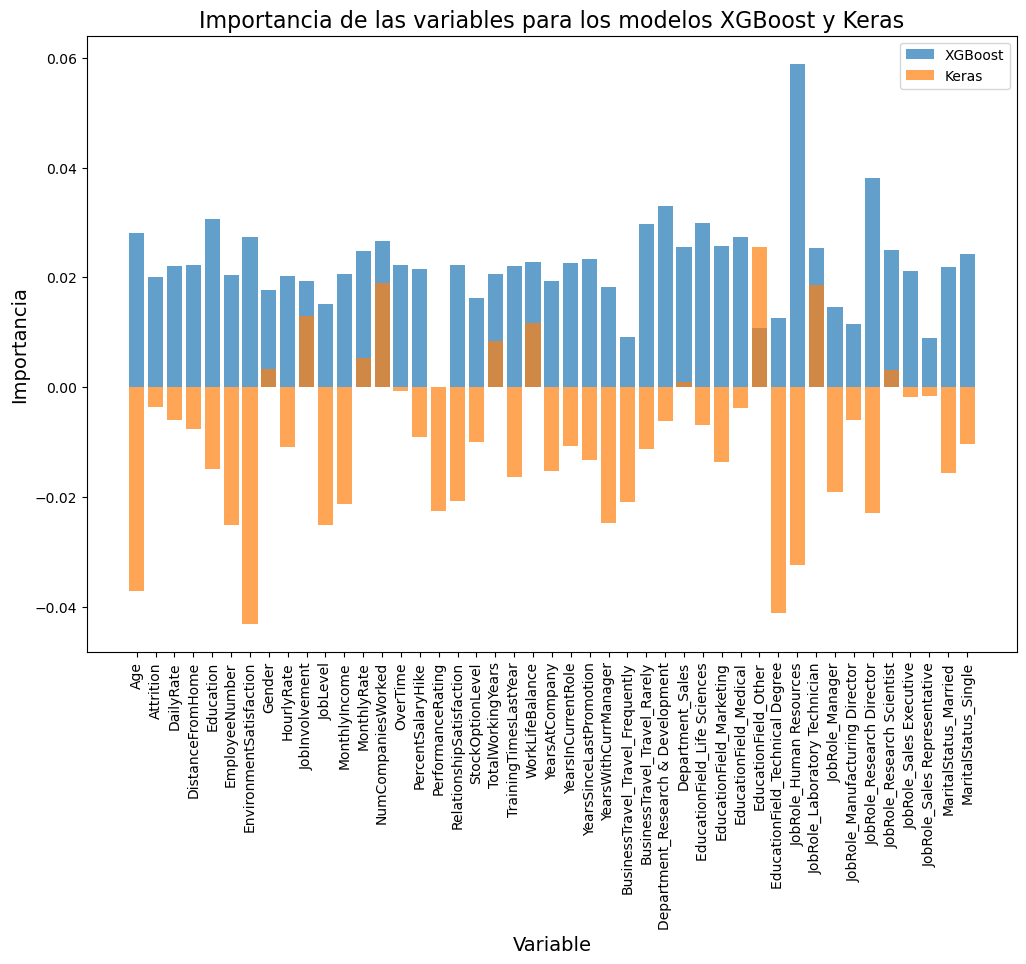

In [10]:
# Obtain importance of the variables of the XGBoost model
xgb_importances = clf_xgb.feature_importances_

# Get importance of Keras model variables
keras_importances = model.layers[0].get_weights()[0].mean(axis=1)

# Create a DataFrame with the importances
importances = pd.DataFrame({
    'Variable': df_bandera.drop(columns=['JobSatisfaction']).columns,
    'XGBoost': xgb_importances,
    'Keras': keras_importances
})


importances.set_index('Variable', inplace=True)
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(importances.index, importances['XGBoost'], color='#1f77b4', alpha=0.7, label='XGBoost')
ax.bar(importances.index, importances['Keras'], color='#ff7f0e', alpha=0.7, label='Keras')
ax.set_title('Importance of variables for the XGBoost and Keras models', fontsize=16)
ax.set_xlabel('Variable', fontsize=14)
ax.set_ylabel('Importance', fontsize=14)
plt.xticks(rotation=90)
ax.legend()
plt.show()

### Let's eliminate the least important columns for each model

In [11]:
# Create a list of columns to delete based on XGBoost importances
xgb_importances = clf_xgb.feature_importances_
xgb_threshold = 0.02
xgb_drop_cols = [col for col, imp in zip(df_bandera.columns, xgb_importances) if abs(imp) < abs(xgb_threshold)]

# Create a list of columns to remove based on the Keras importances
keras_importances = model.layers[0].get_weights()[0].mean(axis=1)
keras_threshold = 0.01
keras_drop_cols = [col for col, imp in zip(df_bandera.columns, keras_importances) if abs(imp) < abs(keras_threshold)]

# Create a new dataframe for XGBoost
df_xgb = df_bandera.drop(xgb_drop_cols, axis=1)
df_xgb['JobSatisfaction'] = df_xgb['JobSatisfaction'].replace({1: 0, 2: 0, 3: 1, 4: 1})

# Create a new dataframe for Keras
df_keras = df_bandera.drop(keras_drop_cols, axis=1)
df_keras['JobSatisfaction'] = df_keras['JobSatisfaction'].replace({1: 0, 2: 0, 3: 1, 4: 1})

print("Columnas eliminadas para XGBoost:", xgb_drop_cols)
print("Columnas eliminadas para Keras:", keras_drop_cols)


Columnas eliminadas para XGBoost: ['Gender', 'JobInvolvement', 'JobLevel', 'PercentSalaryHike', 'RelationshipSatisfaction', 'WorkLifeBalance', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'EducationField_Medical', 'EducationField_Other', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Sales Executive']
Columnas eliminadas para Keras: ['Attrition', 'DailyRate', 'DistanceFromHome', 'Gender', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'RelationshipSatisfaction', 'StockOptionLevel', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Marketing', 'JobRole_Manager', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive']


In [12]:
print("Número de columnas en el dataframe Keras: {}".format(df_keras.shape[1]))
print("Número de columnas en el dataframe XGBoost: {}".format(df_xgb.shape[1]))

Número de columnas en el dataframe Keras: 29
Número de columnas en el dataframe XGBoost: 33


### Let's define the first model

In [13]:
# X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df_xgb.drop('JobSatisfaction', axis=1), df_xgb['JobSatisfaction'], test_size=0.2, random_state=42)
# param_grid_xgb = {
#     'scale_pos_weight': [5, 6, 7, 8, 9, 10, 11],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 0.9, 1],
#     'colsample_bytree': [0.8, 0.9, 1]
# }
# clf_xgb = XGBClassifier()
# grid_search_xgb = GridSearchCV(clf_xgb, param_grid_xgb, scoring='matthews_corrcoef', cv=5)
# grid_search_xgb.fit(X_train_xgb, y_train_xgb)
# print("Mejores parámetros para XGBClassifier: ", grid_search_xgb.best_params_)


Mejores parámetros para XGBClassifier:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 10}

In [14]:
X_train_keras, X_test_keras, y_train_keras, y_test_keras = train_test_split(df_keras.drop('JobSatisfaction', axis=1), df_keras['JobSatisfaction'], test_size=0.2, random_state=42)

# Definir función para crear modelo
def create_model(learning_rate=0.01, optimizer='adam', dropout_rate=0.0, activation='relu'):
    model = keras.Sequential([
        keras.layers.Dense(64, activation=activation, input_shape=(X_train_keras.shape[1],)),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(32, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(16, activation=activation),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definir los parámetros a tunear
param_grid_keras = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'learning_rate': [0.01, 0.001],
    'optimizer': ['adam'],
    'activation': ['relu', 'sigmoid'],
    'dropout_rate': [0.2, 0.3],
    'class_weight': [{0: 1/2, 1: 1/2}, {0: 2/3, 1: 1/3}, {0: 3/4, 1: 1/4}, {0: 4/5, 1: 1/5}]
}

# Entrenar modelo con GridSearchCV
clf_keras = KerasClassifier(build_fn=create_model, verbose=0)
grid_search_keras = GridSearchCV(clf_keras, param_grid_keras, scoring='matthews_corrcoef', cv=5)
grid_search_keras.fit(X_train_keras, y_train_keras)

2023-02-27 01:49:52.928157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 4ms/step


2023-02-27 01:50:14.165367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:50:14.475616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 6ms/step


2023-02-27 01:50:35.465852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:50:35.768732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 5ms/step


2023-02-27 01:50:57.585903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:50:57.928530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 5ms/step


2023-02-27 01:51:19.197700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:51:20.014862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 4ms/step


2023-02-27 01:51:41.285278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:51:41.585372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 4ms/step


2023-02-27 01:52:02.211663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:52:02.508407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 5ms/step


2023-02-27 01:52:23.934402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:52:24.262793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 6ms/step


2023-02-27 01:52:46.909613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:52:47.264079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 5ms/step


2023-02-27 01:53:10.505612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:53:11.526153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 5ms/step


2023-02-27 01:53:35.546291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:53:35.889314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 6ms/step


2023-02-27 01:54:19.461397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 01:54:19.790809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Imprimir los mejores parámetros encontrados
print("Mejores parámetros para Keras: ", grid_search_keras.best_params_)